In [ ]:
# Student Code: Load the dataset
import pandas as pd

# Example: Load your dataset (replace with the actual dataset path or URL)
df = pd.read_csv("/content/NLP Manufacturer Dataset .csv")

# Display the first few rows to understand the structure
df.head(10)

,Input,Prediction
0,The production batch has been inspected thorou...,Compliant
1,"During the final inspection, some units were f...",Minor Defect
2,A critical defect was identified in the batch ...,Major Issue
3,All items in this batch passed the quality con...,Compliant
4,"There are some minor defects in a few units, s...",Minor Defect
5,Several items failed the structural integrity ...,Major Issue
6,The product batch meets all specified quality ...,Compliant
7,"Some of the units show minor cosmetic defects,...",Minor Defect
8,The batch failed quality inspection due to con...,Major Issue
9,All products in this batch were tested for fun...,Compliant


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Input       1549 non-null   object
 1   Prediction  1547 non-null   object
dtypes: object(2)
memory usage: 24.3+ KB
None
                                                    Input    Prediction
count                                                1549          1547
unique                                               1549             3
top     A batch of electrical extension cords had loos...  Minor Defect
freq                                                    1           616


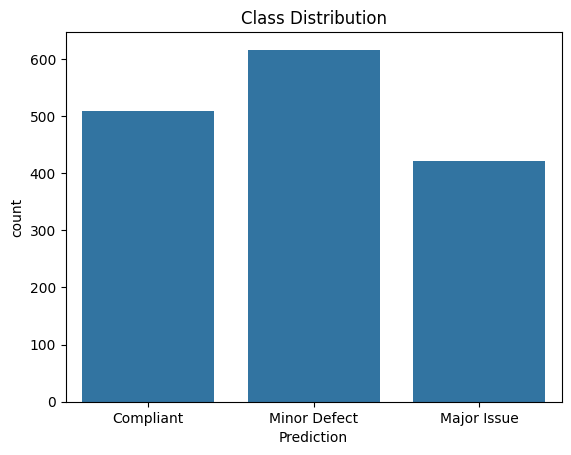

Input         0
Prediction    2
dtype: int64


In [ ]:
# Student Code: Perform EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Display dataset info and summary statistics
print(df.info())
print(df.describe())

# Visualize the class distribution (if it's a classification task)
sns.countplot(x='Prediction', data=df)
plt.title("Class Distribution")
plt.show()

# Check for missing values
print(df.isnull().sum())

In [ ]:
# Student Code: Text Processing (Cleaning the data)
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    return text

# Apply text cleaning to the dataset
df['cleaned_text'] = df['Input'].apply(clean_text)

# Display cleaned text
df[['Input', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Input,cleaned_text
0,The production batch has been inspected thorou...,the production batch has been inspected thorou...
1,"During the final inspection, some units were f...",during the final inspection some units were fo...
2,A critical defect was identified in the batch ...,a critical defect was identified in the batch ...
3,All items in this batch passed the quality con...,all items in this batch passed the quality con...
4,"There are some minor defects in a few units, s...",there are some minor defects in a few units su...


In [ ]:
# Student Code: Generate NLP-based features
import numpy as np

def generate_nlp_features(df):
    # Character count
    df['char_count'] = df['cleaned_text'].apply(len)
    # Word count
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    # Average word length
    df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
    # Stopword count
    df['stopword_count'] = df['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    # Hashtag count (for datasets like tweets)
    df['htag_count'] = df['cleaned_text'].apply(lambda x: x.count('#'))

    return df

# Generate NLP features
df = generate_nlp_features(df)
df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].head()

,char_count,word_count,avg_word_length,stopword_count,htag_count
0,180,26,5.961538,11,0
1,184,30,5.166667,15,0
2,226,34,5.647059,13,0
3,168,25,5.760000,10,0
4,202,34,4.970588,20,0


In [ ]:
!pip install fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2025-04-03 07:52:56--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.118, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   292MB/s    in 15s     

2025-04-03 07:53:11 (284 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
# Student Code: Generate Bag of Words, TFIDF, and FastText features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext

# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# FastText embeddings (example using pre-trained FastText model)
ft_model = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text):
    words = text.split()
    word_vectors = [ft_model.get_word_vector(word) for word in words]
    return np.mean(word_vectors, axis=0)

df['fasttext_embeddings'] = df['cleaned_text'].apply(get_fasttext_embeddings)

In [ ]:
# Student Code: Train Models on NLP Features (char_count, word_count, etc.)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd # Import pandas for data manipulation

# Split data
X = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Prediction']

# Before splitting, remove rows with NaN values in X or y
df_cleaned = df.dropna(subset=X.columns.tolist() + [y.name]) # Drop rows with NaN in specified columns
X = df_cleaned[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']] # Reassign X and y after cleaning
y = df_cleaned['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Train model (Random Forest as an example)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.42326332794830374


In [ ]:
# Section 6 - Random Forest
X = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Prediction']

# Before splitting, remove rows with NaN values in X or y
df_cleaned = df.dropna(subset=X.columns.tolist() + [y.name]) # Drop rows with NaN in specified columns
X = df_cleaned[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']] # Reassign X and y after cleaning
y = df_cleaned['Prediction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y
)

model = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.4860


In [ ]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Re-calculate X and X_tfidf after data cleaning
X = df_cleaned[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['cleaned_text']) # Recalculate X_tfidf

# Combine NLP features and TFIDF features
X_combined = hstack([X, X_tfidf])

# Train model and evaluate
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)  # Add random_state
model = RandomForestClassifier() # Re-initialize the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Combined Features Accuracy: {accuracy_score(y_test, y_pred)}')

Combined Features Accuracy: 0.867741935483871


In [ ]:
import joblib

# Save the trained model
joblib.dump(model, 'text_classification_model.pkl')

# Load the model for predictions
loaded_model = joblib.load('text_classification_model.pkl')

# Example: Make predictions on real-world input (e.g., a new text)
new_text = ["A few products in this batch have minor cosmetic flaws such as surface scratches or slight dents, but these issues do not affect the performance or safety of the items."]
new_text_cleaned = [clean_text(text) for text in new_text]

# Generate NLP features for the new text
new_text_df = pd.DataFrame({'cleaned_text': new_text_cleaned})  # Create a DataFrame
new_text_df = generate_nlp_features(new_text_df)  # Apply the feature generation function

# TFIDF features for the new text
new_text_tfidf = tfidf_vectorizer.transform(new_text_cleaned)

# Combine NLP and TFIDF features for the new text
X_new = new_text_df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
X_new_combined = hstack([X_new, new_text_tfidf])  # Combine features

# Predict using the trained model
prediction = loaded_model.predict(X_new_combined)
print(f'Prediction for new text: {prediction}')

Prediction for new text: ['Minor Defect']


**SVM**

In [ ]:
# Student Code: Train Models on NLP Features (char_count, word_count, etc.) using SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split data
X = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Prediction']

# Before splitting, remove rows with NaN values in X or y
df_cleaned = df.dropna(subset=X.columns.tolist() + [y.name])  # Drop rows with NaN in specified columns
X = df_cleaned[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]  # Reassign X and y after cleaning
y = df_cleaned['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train model (SVM)
model = SVC(kernel='linear')  # You can change kernel to 'rbf', 'poly', etc., as needed
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.432258064516129


In [ ]:
# Initialize SVM model
svm_model = SVC(kernel='linear')  # You can change kernel to 'rbf', 'poly', etc.

# Before splitting, ensure X_bow and y have the same number of samples
# This is likely due to the data cleaning step in cell 25, which might have removed rows with NaNs
X_bow_cleaned = X_bow[df_cleaned.index]  # Select rows from X_bow that correspond to the cleaned df

# Train and evaluate on Bag of Words (BoW)
X_train, X_test, y_train, y_test = train_test_split(X_bow_cleaned, y, test_size=0.3)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on FastText embeddings
# Ensure fasttext_embeddings and y have the same length after data cleaning
fasttext_embeddings_cleaned = np.vstack(df_cleaned['fasttext_embeddings']) # Use df_cleaned instead of df
X_train, X_test, y_train, y_test = train_test_split(fasttext_embeddings_cleaned, y, test_size=0.3)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred)}')

BoW Accuracy: 0.875268817204301
TFIDF Accuracy: 0.875268817204301
FastText Accuracy: 0.8451612903225807


In [ ]:
# SVM with TFIDF and BOW
from scipy.sparse import hstack

# Before combining, recalculate TFIDF based on the cleaned text data to ensure consistent dimensions
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['cleaned_text'])
X_bow_cleaned = X_bow[df_cleaned.index] # Select the rows in X_bow corresponding to the cleaned data

# Combine TFIDF and Bag of Words features
X_combined = hstack([X_tfidf, X_bow_cleaned])  # Use X_bow_cleaned

# Train and evaluate SVM with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(f'SVM with TFIDF + BoW Accuracy: {accuracy_score(y_test, y_pred)}')

SVM with TFIDF + BoW Accuracy: 0.8193548387096774


**Logistic Regression**

In [ ]:
# Student Code: Train models on NLP Features (char_count, word_count, etc.) using Logistic Regression
# Split data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Prediction']

# Before splitting, remove rows with NaN values in X or y
df_cleaned = df.dropna(subset=X.columns.tolist() + [y.name])  # Drop rows with NaN in specified columns
X = df_cleaned[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]  # Reassign X and y after cleaning
y = df_cleaned['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train model (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.44516129032258067


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Initialize Logistic Regression model
log_model = LogisticRegression()

# Before splitting, ensure X_bow and y have the same number of samples
# Recalculate X_bow, X_tfidf, fasttext_embeddings based on df_cleaned
X_bow = bow_vectorizer.fit_transform(df_cleaned['cleaned_text'])  # Recalculate X_bow
X_tfidf = tfidf_vectorizer.fit_transform(df_cleaned['cleaned_text'])  # Recalculate X_tfidf
fasttext_embeddings_cleaned = np.vstack(df_cleaned['fasttext_embeddings'])  # Use df_cleaned for FastText

# Train and evaluate on Bag of Words (BoW)
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.3, random_state=42)  # Add random_state for reproducibility
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)  # Add random_state
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on FastText embeddings
X_train, X_test, y_train, y_test = train_test_split(fasttext_embeddings_cleaned, y, test_size=0.3, random_state=42)  # Add random_state
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred)}')

BoW Accuracy: 0.843010752688172
TFIDF Accuracy: 0.8602150537634409
FastText Accuracy: 0.8193548387096774


In [ ]:
# Combine TFIDF and Bag of Words features
X_combined = hstack([X_tfidf, X_bow])

# Train and evaluate Logistic Regression with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
print(f'Logistic Regression with TFIDF + BoW Accuracy: {accuracy_score(y_test, y_pred)}')

Logistic Regression with TFIDF + BoW Accuracy: 0.8795698924731182


**KNN**

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train and evaluate KNN with TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f'KNN with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')


KNN with TFIDF Accuracy: 0.832258064516129


In [ ]:
# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate on Bag of Words (BoW)
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f'KNN with BoW Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f'KNN with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on FastText embeddings
# Ensure fasttext_embeddings and y have the same length after data cleaning
fasttext_embeddings_cleaned = np.vstack(df_cleaned['fasttext_embeddings']) # Use df_cleaned instead of df
X_train, X_test, y_train, y_test = train_test_split(fasttext_embeddings_cleaned, y, test_size=0.2, random_state=42)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f'KNN with FastText Accuracy: {accuracy_score(y_test, y_pred)}')

KNN with BoW Accuracy: 0.8225806451612904
KNN with TFIDF Accuracy: 0.832258064516129
KNN with FastText Accuracy: 0.8258064516129032


In [ ]:
# Combine TFIDF and Bag of Words features
X_combined = hstack([X_tfidf, X_bow])

# Train and evaluate KNN with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
print(f'KNN with TFIDF + BoW Accuracy: {accuracy_score(y_test, y_pred)}')


KNN with TFIDF + BoW Accuracy: 0.8387096774193549


**Decision Tree**

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate Decision Tree with TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f'Decision Tree with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

Decision Tree with TFIDF Accuracy: 0.7677419354838709


In [ ]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier()

# Train and evaluate on Bag of Words (BoW)
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f'Decision Tree with BoW Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f'Decision Tree with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on FastText embeddings
# Use fasttext_embeddings from the cleaned DataFrame (df_cleaned)
X_train, X_test, y_train, y_test = train_test_split(np.vstack(df_cleaned['fasttext_embeddings']), y, test_size=0.2, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f'Decision Tree with FastText Accuracy: {accuracy_score(y_test, y_pred)}')

Decision Tree with BoW Accuracy: 0.7741935483870968
Decision Tree with TFIDF Accuracy: 0.7645161290322581
Decision Tree with FastText Accuracy: 0.6548387096774193


In [ ]:
# Train and evaluate Decision Tree with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f'Decision Tree with TFIDF + BoW Accuracy: {accuracy_score(y_test, y_pred)}')

Decision Tree with TFIDF + BoW Accuracy: 0.7612903225806451


**Naive Bayes**

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Train and evaluate Naïve Bayes with TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(f'Naïve Bayes with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')


Naïve Bayes with TFIDF Accuracy: 0.8709677419354839


In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Initialize MultinomialNB for BoW and TFIDF (only works with non-negative values)
nb_model = MultinomialNB()

# Train and evaluate on Bag of Words (BoW)
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(f'Naïve Bayes with BoW Accuracy: {accuracy_score(y_test, y_pred)}')

# Train and evaluate on TFIDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(f'Naïve Bayes with TFIDF Accuracy: {accuracy_score(y_test, y_pred)}')

# ---- Handling FastText embeddings ---- #
# Use GaussianNB for FastText since it allows negative values
nb_gaussian = GaussianNB()

# Train and evaluate on FastText embeddings
# Use fasttext_embeddings from the cleaned DataFrame (df_cleaned) to ensure consistent length with y
X_train, X_test, y_train, y_test = train_test_split(np.vstack(df_cleaned['fasttext_embeddings']), y, test_size=0.2, random_state=42)
nb_gaussian.fit(X_train, y_train)
y_pred = nb_gaussian.predict(X_test)
print(f'Naïve Bayes (GaussianNB) with FastText Accuracy: {accuracy_score(y_test, y_pred)}')

Naïve Bayes with BoW Accuracy: 0.864516129032258
Naïve Bayes with TFIDF Accuracy: 0.8709677419354839
Naïve Bayes (GaussianNB) with FastText Accuracy: 0.8193548387096774


In [ ]:
# Train and evaluate Naïve Bayes with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
print(f'Naïve Bayes with TFIDF + BoW Accuracy: {accuracy_score(y_test, y_pred)}')

Naïve Bayes with TFIDF + BoW Accuracy: 0.867741935483871


**Analysis:**

### Comparative Analysis of Classification Models

| Model                | Accuracy with TFIDF | Accuracy with FastText | Accuracy with BoW | Accuracy with TFIDF + BoW |
|----------------|-------|----------|-----------|--------|
| SVM            | 0.8752   | 0.8451      | 0.8752       | 0.8193    |
| Random Forest  |0.4232    | 0.4860      | 0.8601       | 0.8677    |
| Logistic Regression   | 0.8602     | 0.8193         | 0.8430      | 0.8795   |
| KNN            | 0.8322  | 0.8258     | 0.8225         | 0.8387    |
| Decision Tree  | 0.7677  | 0.6548     | 0.7741         | 0.7612    |
| Naive Bayes    | 0.8709  | 0.8193     | 0.8645         | 0.8677    |

After comparative analysis of different classification models, Logistic Regression is suited as the best model with the accuracy of 87.95%